In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
# from NeuralNet import *
from timeit import default_timer

from Solver import nummodel, nummodel_flux, explicit_solve
import sys
sys.path.append('../Utility')
import NeuralNet
from Numerics import gradient_first


# Load data

In [11]:
def load_data(data_dir):
    closure = -scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
    dq_dy   =  scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
    q       =  scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]
    
    _, Ny, Nt = closure.shape

    q_mean = np.mean(q[0, :, Nt//2:], axis=1)
    dq_dy_mean = np.mean(dq_dy[0, :, Nt//2:], axis=1)
    closure_mean = np.mean(closure[0, :, Nt//2:], axis=1)

    return closure_mean, q_mean, dq_dy_mean

N_y = 384
beta = 1.0
# data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_0.01/", "../data/beta_1.0_Gamma_1.0_relax_0.02/", "../data/beta_1.0_Gamma_1.0_relax_0.04/", "../data/beta_1.0_Gamma_1.0_relax_0.08/", "../data/beta_1.0_Gamma_1.0_relax_0.16/"]
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_0.01/"]

N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]


# TODO: clean data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)




# Visualize data

TypeError: 'AxesSubplot' object is not subscriptable

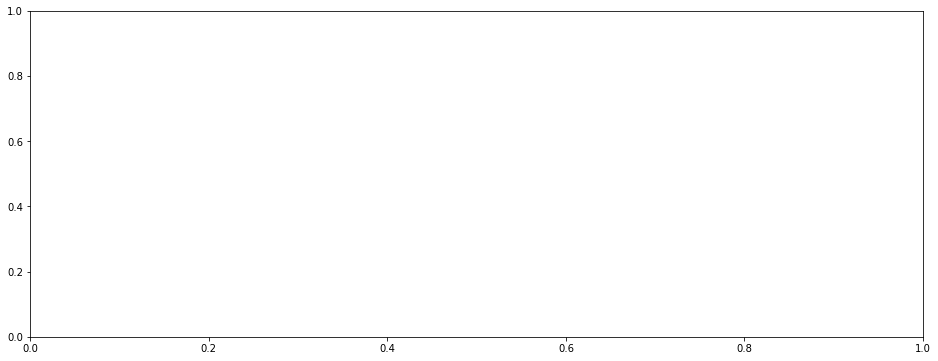

In [12]:
# compare dq_dy_mean vs dq_dy
dq_mean_dy = np.zeros(dq_dy_mean.shape)
for i in range(N_data): 
    dq_mean_dy[i, :] = gradient_first(q_mean[i, :], dy, bc = "one-sided")

fig, ax = plt.subplots(nrows=1, ncols=N_data, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[i].plot(dq_dy_mean[i,:], yy)
    ax[i].plot(dq_mean_dy[i,:], yy, "--")
    ax[i].set_xlabel("dq_dy")
    

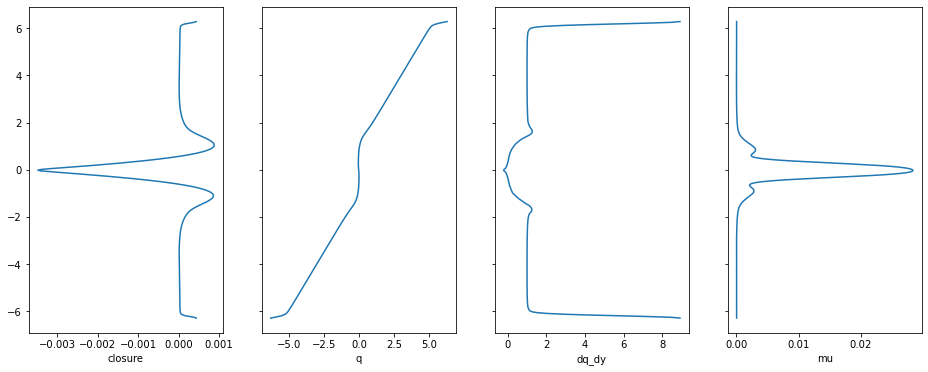

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], yy)
    ax[1].plot(q_mean[i,:], yy)
    ax[2].plot(dq_dy_mean[i,:], yy)
    ax[3].plot(mu_f[i,:], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dq_dy")
    ax[3].set_xlabel("mu")

In [14]:
nn_save_name = "quadratic.nn"

chop_l = 15
closure_mean_chop = closure_mean[:, chop_l:-chop_l]
q_mean_chop = q_mean[:, chop_l:-chop_l]
q_mean_abs_chop = q_mean_abs[:, chop_l:-chop_l]
dq_dy_mean_chop = dq_dy_mean[:, chop_l:-chop_l]
mu_f_chop = mu_f[:, chop_l:-chop_l]
yy_chop = yy[chop_l:-chop_l]





In [15]:
print(np.linalg.norm(mu_f_chop))

0.11186918429520883


In [24]:
x_train = torch.from_numpy(np.stack((q_mean_abs_chop.flatten(), dq_dy_mean_chop.flatten())).T.astype(np.float32))
y_train = torch.from_numpy(mu_f_chop.flatten()[:,np.newaxis].astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 200000
batch_size = 1024 #64

layers = 2
width  = 20
activation='tanh'
initializer='default'
outputlayer='None'

nn_model = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 
optimizer = NeuralNet.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
for ep in range(epochs):
    nn_model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = nn_model(x)
        
        loss = myloss(out , y)*1000
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
    if nn_save_name is not None:
        torch.save(nn_model, nn_save_name)
        

# for ep in range(epochs):
#     nn_model.train()
#     out = nn_model(x_train)
#     loss = myloss(out , y_train)*1000
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
       
#     if ep % 1000 == 0:
#         # train_l2/= ntrain
#         t2 = default_timer()
#         print("[{}/{}], loss: {}, time {}".format(ep, epochs, np.round(loss.item(), 3), t2-t1))
		
#         if nn_save_name is not None:
#             torch.save(nn_model, nn_save_name)
       

Epoch :  0  Epoch time :  0.002778577999947629  Train L2 Loss :  26583.6171875
Epoch :  100  Epoch time :  0.0021176120000063747  Train L2 Loss :  424.4876708984375
Epoch :  200  Epoch time :  0.0021934270000656397  Train L2 Loss :  283.73248291015625
Epoch :  300  Epoch time :  0.002155590000029406  Train L2 Loss :  242.85516357421875
Epoch :  400  Epoch time :  0.0020502379999243203  Train L2 Loss :  224.66078186035156
Epoch :  500  Epoch time :  0.0024329740000439415  Train L2 Loss :  215.36483764648438
Epoch :  600  Epoch time :  0.002284047999978611  Train L2 Loss :  210.41586303710938
Epoch :  700  Epoch time :  0.0020918449999953737  Train L2 Loss :  207.747802734375
Epoch :  800  Epoch time :  0.002218479999896772  Train L2 Loss :  206.30621337890625
Epoch :  900  Epoch time :  0.0020354760000600436  Train L2 Loss :  205.5281982421875
Epoch :  1000  Epoch time :  0.00348472899997887  Train L2 Loss :  205.10960388183594
Epoch :  1100  Epoch time :  0.0020574239999859856  Train L

Epoch :  9400  Epoch time :  0.002446423000037612  Train L2 Loss :  204.64297485351562
Epoch :  9500  Epoch time :  0.0024973649999537884  Train L2 Loss :  204.64297485351562
Epoch :  9600  Epoch time :  0.0021511150000605994  Train L2 Loss :  204.64297485351562
Epoch :  9700  Epoch time :  0.0020744890000514715  Train L2 Loss :  204.64297485351562
Epoch :  9800  Epoch time :  0.003217037000013079  Train L2 Loss :  204.64297485351562
Epoch :  9900  Epoch time :  0.002145459000075789  Train L2 Loss :  204.64297485351562
Epoch :  10000  Epoch time :  0.002385768000067401  Train L2 Loss :  204.64297485351562
Epoch :  10100  Epoch time :  0.002192774999912217  Train L2 Loss :  204.64297485351562
Epoch :  10200  Epoch time :  0.0020792640000308893  Train L2 Loss :  204.64297485351562
Epoch :  10300  Epoch time :  0.002537071000006108  Train L2 Loss :  204.64297485351562
Epoch :  10400  Epoch time :  0.002178342999968663  Train L2 Loss :  204.64297485351562
Epoch :  10500  Epoch time :  0.00

KeyboardInterrupt: 

# Test on training data

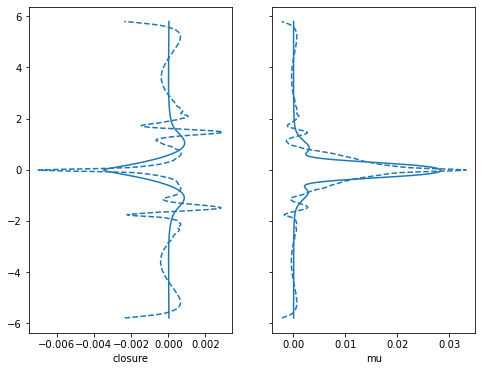

In [22]:
y_pred = nn_model(x_train).detach().numpy().reshape((N_data, -1))


fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))
for i in range(N_data):
    ax[0].plot(closure_mean_chop[i,:], yy_chop, color="C"+str(i))
    ax[1].plot(mu_f_chop[i,:], yy_chop, color="C"+str(i))
    
    ax[0].plot(y_pred[i,:]*dq_dy_mean_chop[i,:], yy_chop, "--", color="C"+str(i))
    ax[1].plot(y_pred[i,:], yy_chop, "--", color="C"+str(i))
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("mu")
    


# Plug-in test

In [7]:
beta = 1.0
N_y = 384
omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
q_jet = omega_jet + beta*yy


tau_inv = "0.16"
# tau_inv = "0.16"                                                                                                                
tau = 1/float(tau_inv)
data_dir = "../data/beta_1.0_Gamma_1.0_relax_" + tau_inv + "/"
dq_dy = scipy.io.loadmat(data_dir+"data_dq_dy.mat")["data_dq_dy"]
closure = scipy.io.loadmat(data_dir+"data_closure_cons.mat")["data_closure_cons"]
w = scipy.io.loadmat(data_dir+"data_w.mat")["data_w"]
q = scipy.io.loadmat(data_dir+"data_q.mat")["data_q"]

_, Ny, Nt = q.shape
q_mean = np.mean(q[0, :, Nt//2:], axis=1)
w_mean = np.mean(w[0, :, Nt//2:], axis=1)

def nn_flux(q, dq):
    x = np.vstack((np.fabs(q), dq)).T
    mu = nn_model(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
    return mu*dq


model = lambda q, yy, res : nummodel_flux(nn_flux, q, yy, res)
dt, Nt, save_every = 1.0e-3, 200000, 100
yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = 4*np.pi)
q_mean_pred = np.mean(q_data[Nt//(2*save_every):, :], axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean, yy,   label="ref")                                                                         
ax[0].plot(q_mean_pred, yy, label="plug-in")
ax[1].plot(w_mean, yy,   label="ref")                                                                         
ax[1].plot(q_mean_pred - beta*yy, yy, label="plug-in")
ax[0].set_xlabel("q")
ax[1].set_xlabel("omega")
                                                                                                            
plt.legend()
plt.show()
                                                                                      


 



100 max q 12124.773940365894
200 max q 867317107.8734611
300 max q 114518774514040.4
400 max q 1.5302087394282879e+19
500 max q 2.0453819609038198e+24
600 max q 2.7340036051552728e+29
700 max q 3.6545633115740427e+34
800 max q nan
900 max q nan
1000 max q nan
1100 max q nan
1200 max q nan
1300 max q nan
1400 max q nan
1500 max q nan
1600 max q nan
1700 max q nan
1800 max q nan
1900 max q nan
2000 max q nan
2100 max q nan
2200 max q nan
2300 max q nan
2400 max q nan
2500 max q nan
2600 max q nan
2700 max q nan
2800 max q nan
2900 max q nan
3000 max q nan
3100 max q nan
3200 max q nan
3300 max q nan
3400 max q nan
3500 max q nan
3600 max q nan
3700 max q nan
3800 max q nan
3900 max q nan
4000 max q nan
4100 max q nan
4200 max q nan
4300 max q nan
4400 max q nan
4500 max q nan
4600 max q nan
4700 max q nan
4800 max q nan
4900 max q nan
5000 max q nan
5100 max q nan
5200 max q nan
5300 max q nan
5400 max q nan
5500 max q nan
5600 max q nan
5700 max q nan
5800 max q nan
5900 max q nan
6000 

52000 max q nan
52100 max q nan
52200 max q nan
52300 max q nan
52400 max q nan
52500 max q nan
52600 max q nan
52700 max q nan
52800 max q nan
52900 max q nan
53000 max q nan
53100 max q nan
53200 max q nan
53300 max q nan
53400 max q nan
53500 max q nan
53600 max q nan
53700 max q nan
53800 max q nan
53900 max q nan
54000 max q nan
54100 max q nan
54200 max q nan
54300 max q nan
54400 max q nan
54500 max q nan
54600 max q nan
54700 max q nan
54800 max q nan
54900 max q nan
55000 max q nan
55100 max q nan
55200 max q nan
55300 max q nan
55400 max q nan
55500 max q nan
55600 max q nan
55700 max q nan
55800 max q nan
55900 max q nan
56000 max q nan
56100 max q nan
56200 max q nan
56300 max q nan
56400 max q nan
56500 max q nan
56600 max q nan
56700 max q nan
56800 max q nan
56900 max q nan
57000 max q nan
57100 max q nan
57200 max q nan
57300 max q nan
57400 max q nan
57500 max q nan
57600 max q nan
57700 max q nan
57800 max q nan
57900 max q nan
58000 max q nan
58100 max q nan
58200 ma

104100 max q nan
104200 max q nan
104300 max q nan
104400 max q nan
104500 max q nan
104600 max q nan
104700 max q nan
104800 max q nan
104900 max q nan
105000 max q nan
105100 max q nan
105200 max q nan
105300 max q nan
105400 max q nan
105500 max q nan
105600 max q nan
105700 max q nan
105800 max q nan
105900 max q nan
106000 max q nan
106100 max q nan
106200 max q nan
106300 max q nan
106400 max q nan
106500 max q nan
106600 max q nan
106700 max q nan
106800 max q nan
106900 max q nan
107000 max q nan
107100 max q nan
107200 max q nan
107300 max q nan
107400 max q nan
107500 max q nan
107600 max q nan
107700 max q nan
107800 max q nan
107900 max q nan
108000 max q nan
108100 max q nan
108200 max q nan
108300 max q nan
108400 max q nan
108500 max q nan
108600 max q nan
108700 max q nan
108800 max q nan
108900 max q nan
109000 max q nan
109100 max q nan
109200 max q nan
109300 max q nan
109400 max q nan
109500 max q nan
109600 max q nan
109700 max q nan
109800 max q nan
109900 max q n

152600 max q nan
152700 max q nan
152800 max q nan
152900 max q nan
153000 max q nan
153100 max q nan
153200 max q nan
153300 max q nan
153400 max q nan
153500 max q nan
153600 max q nan
153700 max q nan
153800 max q nan
153900 max q nan
154000 max q nan
154100 max q nan
154200 max q nan
154300 max q nan
154400 max q nan
154500 max q nan
154600 max q nan
154700 max q nan
154800 max q nan
154900 max q nan
155000 max q nan
155100 max q nan
155200 max q nan
155300 max q nan
155400 max q nan
155500 max q nan
155600 max q nan
155700 max q nan
155800 max q nan
155900 max q nan
156000 max q nan
156100 max q nan
156200 max q nan
156300 max q nan
156400 max q nan
156500 max q nan
156600 max q nan
156700 max q nan
156800 max q nan
156900 max q nan
157000 max q nan
157100 max q nan
157200 max q nan
157300 max q nan
157400 max q nan
157500 max q nan
157600 max q nan
157700 max q nan
157800 max q nan
157900 max q nan
158000 max q nan
158100 max q nan
158200 max q nan
158300 max q nan
158400 max q n

NameError: name 'q_data' is not defined